# The Quantum Approximate Optimization Algorithm for MAX-CUT

The following is a step-by-step guide to running QAOA on the MaxCut problem.  In the debue paper on QAOA (arXiv: 1411.4028), Farhi, Goldstone, and Gutmann demonstrate that the lowest order approximation of the algorithm produced an approximation ratio of 0.6946 for the MaxCut problem on three-regular graphs.  You can use this notebook to set up an arbitary graph for MaxCut and solve it using the QAOA algorithm the Rigetti Forest service.

``pyQAOA`` is a python library that implements the QAOA.  It uses the `PauliTerm` and `PauliSum` objects from the pyQuil library for expressing the cost Hamiltonian and driver Hamiltonain. These operators are used to create a parametric pyQuil program and passed to the variational quantum eigensolver (VQE) solver in Grove.  VQE calls the Rigetti Forest QVM to exectue the Quil program that prepares the angle parameterized state.  There are multiple ways to construct the MAX-CUT problem for the QAOA library.  We include a method that accepts a graph and returns a QAOA instance where the costs and driver Hamiltonaians have been constructed.  The graph is either an undirected Networkx graph or a list of tuples where each tuple represents an edge between a pair of nodes.

We start by demonstrating the QAOA algorithm with the simplest instance of MAX-CUT--parititioning the nodes on a barbell graph.  The barbell graph corresponds to a single edge connecting two nodes.  The solution is the partitioning of the nodes into different sets $\{0, 1\}$. 

In [1]:
import numpy as np
from grove.pyqaoa.maxcut_qaoa import maxcut_qaoa
barbell = [(0, 1)]  # graph is a defined by a list of edges.  Edge weights are assumed to be 1.0
steps = 1  # evolution path length between the ref hamiltonian and cost hamiltonian
inst = maxcut_qaoa(barbell, steps=steps)  # initializing problem instance

/home/apolloreno/anaconda3/envs/estuary/lib/python3.7/site-packages/pyquil/api/_compiler.py:324: UserWarning: No quilc server running at tcp://127.0.0.1:5555. Compilation using quilc will not be available.
  warnings.warn(f'{e}. Compilation using quilc will not be available.')


The cost Hamiltonian and driver Hamiltonian corresponding to the barbell graph are stored in `QAOA` object fields in the form of lists of PauliSums. 

In [2]:
from functools import reduce
cost_list, ref_list = inst.cost_ham, inst.ref_ham
cost_ham = reduce(lambda x,y: x + y, cost_list)
ref_ham = reduce(lambda x,y: x + y, ref_list)
print(cost_ham)
print(ref_ham)

(0.5+0j)*Z0*Z1 + (-0.5+0j)*I
(-1+0j)*X0 + (-1+0j)*X1


The identity term above is not necessary to the computation since global phase rotations on the wavefunction do not change the expectation value.  We include it here purely as a demonstration.  The cost function printed above is the negative of the traditional maximum cut cost operator.  This is because QAOA is formulated as the maximization of the cost operator but the VQE algorithm in the pyQuil library performs a minimization.

QAOA requires the construction of a state parameterized by $\beta$ and $\gamma$ rotation angles
$$\begin{align}
\mid \beta, \gamma \rangle = \prod_{p=0}^{\mathrm{steps}}\left( U(\hat{H}_{\mathrm{drive}}, \beta_{p})U(\hat{H}_{\mathrm{MAXCUT}}, \gamma_{p}) \right)^{\mathrm{steps}} (\mid +\rangle_{N-1}\otimes\mid + \rangle_{N-2}...\otimes\mid + \rangle_{0}).
\end{align}$$
The unitaries $U(\hat{H}_{\mathrm{drive}}, \beta_{p})$ and $U(\hat{H}_{\mathrm{MAXCUT}}, \gamma_{p})$ are the exponentiation of the driver Hamiltonian and the cost Hamiltonian, respectively. 
$$
\begin{align}
U(\hat{H}_{\mathrm{ref}}, \beta_{p}) = e^{-i \beta_{p} \hat{H}_{drive}} \\
U(\hat{H}_{\mathrm{MAXCUT}}, \gamma_{p}) = e^{-i \gamma_{p} \hat{H}_{\mathrm{MAXCUT}}}
\end{align}
$$

The QAOA algorithm relies on many constructions of a wavefunction via parameterized Quil and measurements on all qubits to evaluate an expectation value.  In order avoid needless classical computation, QAOA constructs this parametric program once at the beginning of the calculation and then uses this same program object throughout the computation.  This is accomplished using the `ParametricProgram` object from pyQuil that allows us to slot in a symbolic value for a parameterized gate.  

The parameterized program object can be accessed through the `QAOA` method `get_parameterized_program()`.  Calling this method on an instantiated `QAOA` object returns a closure with a precomputed set of Quil programs.  Calling this closure with the parameters $\beta$ and $\gamma$ returns the circuit that has the rotations parameterized.

In [3]:
param_prog = inst.get_parameterized_program()
prog = param_prog([1.2, 4.2])
print(prog)

H 0
H 1
CNOT 0 1
RZ(4.2) 1
CNOT 0 1
X 0
PHASE(2.1) 0
X 0
PHASE(2.1) 0
H 0
RZ(-2.4) 0
H 0
H 1
RZ(-2.4) 1
H 1



The printed program above is a Quil program that can be executed on a QVM.  QAOA has two modes of operation: 1) pre-computing the angles of rotation classically and using the quantum computer to measure expectation values through repeated experiments and 2) installing the a classical optimization loop on top of step 1 to optimally determine the angles.  Operation mode 2 is known as the variational quantum eigensolver algorithm.  the `QAOA` object wraps the instantiation of the VQE algorithm with the `get_angles()` method.  

In [4]:
betas, gammas = inst.get_angles()
print(betas, gammas)

                     models will be ineffective
	Parameters: [1.94980229 1.4744023 ] 
	E => 0.0015337456362040647
	Parameters: [1.98381047 1.51535792] 
	E => 0.0012077609643334486
	Parameters: [1.98381047 1.51535792] 
	E => 0.0015533454458819262
	Parameters: [1.9512193  1.53071628] 
	E => 0.0005018775110684492
	Parameters: [1.9512193  1.53071628] 
	E => 0.0009440667030610195
	Parameters: [1.95263631 1.58703025] 
	E => 0.0017344383549392495
	Parameters: [1.96857764 1.56527258] 
	E => 5.546960010061053e-05
	Parameters: [1.96857764 1.56527258] 
	E => 0.0001050191734196515
	Parameters: [1.95978777 1.58455052] 
	E => 5.113693939540198e-05
	Parameters: [1.9630646  1.55095411] 
	E => 0.00024455655341537597
	Parameters: [1.96500191 1.56651245] 
	E => 6.833004222661643e-06
	Parameters: [1.96191051 1.5716419 ] 
	E => 5.113152035884916e-06
	Parameters: [1.96191051 1.5716419 ] 
	E => 6.787833086330242e-06
[1.96191051] [1.5716419]


``get_angles()`` returns optimal the $\beta$ and $\gamma$ angles.  To view the probabilities of the state you can call ``QAOA.probabilities(t)`` were ``t`` is a concatentation of the $\beta$ and $\gamma$ angles, in that order.  The ``probabilities(t)`` routine takes the $\beta$ and $\gamma$ parameters, reconstructs the wave function and returns their coefficients.  A modified version can be used to print off the probabilities

In [5]:
from pyquil.api import WavefunctionSimulator

param_prog = inst.get_parameterized_program()
t = np.hstack((betas, gammas))
prog = param_prog(t)

wf = WavefunctionSimulator().wavefunction(prog)
wf = wf.amplitudes
for ii in range(2**len(inst.qubits)):
    print(inst.states[ii], np.conj(wf[ii])*wf[ii])

00 (5.11315203590504e-06+0j)
01 (0.4999948868479635+0j)
10 (0.4999948868479635+0j)
11 (5.11315203590504e-06+0j)


As expected the bipartitioning of a graph with a single edge connecting two nodes corresponds to the state $\{|01\rangle, |10\rangle \}$.  In this trivial example the QAOA finds angles that construct a distribution peaked around the two degenerate solutions.

## MAXCUT on larger graphs and alternative optimizers.

Larger graph instances and different classical optimizers can be used with the QAOA.  Here we consider an 6-node ring of disagrees.  For an even number ring graph, the ring of disagrees corresponds to the antiferromagnet ground state--i.e. alternating spin-up spin-down.  

In [3]:
%matplotlib inline

from grove.pyqaoa.qaoa import QAOA
import networkx as nx
import matplotlib.pyplot as plt
from pyquil.paulis import PauliSum, PauliTerm
import pyquil.quil as pq
from pyquil.gates import H

In [7]:
# define a 6-qubit ring
ring_size = 6
graph = nx.Graph()
for i in range(ring_size):
    graph.add_edge(i, (i + 1) % ring_size)

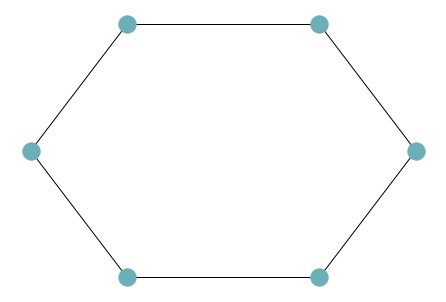

In [8]:
nx.draw_circular(graph, node_color="#6CAFB7")

This graph could be passed to the `maxcut_qaoa` method and a `QAOA` instance with the correct driver and cost Hamiltonian could be generated as before.  In order to demonstrate the more general approach, along with some VQE options, we will construct the cost and driver Hamiltonians directly with `PauliSum` and `PauliTerm` objects.  To do this we parse the edges and nodes of the graph to construct the relevant operators.
$$
\begin{align}
\hat{H}_{\mathrm{cost}} = \sum_{\langle i, j\rangle \in E}\frac{\sigma_{i}^{z}\sigma_{j}^{z} - 1}{2} \\
\hat{H}_{\mathrm{drive}} = \sum_{i}^{n}-\sigma_{i}^{x}
\end{align}
$$
where $\langle i, j\rangle \in E$ refers to the pairs of nodes that form the edges of the graph.

In [9]:
cost_operators = []
driver_operators = []
for i, j in graph.edges():
    cost_operators.append(PauliTerm("Z", i, 0.5)*PauliTerm("Z", j) + PauliTerm("I", 0, -0.5))
for i in graph.nodes():
    driver_operators.append(PauliSum([PauliTerm("X", i, 1.0)]))

We will also construct the initial state and pass this to the QAOA object.  By default `QAOA` uses the $|+\rangle$ tensor product state.  In other notebooks we will demonstrate that you can use the `driver_ref` optional argument to pass a different starting state for QAOA.

In [10]:
prog = pq.Program()
for i in graph.nodes():
    prog.inst(H(i))

Now we are ready to instantiate the QAOA object!

In [11]:
from pyquil.api import local_forest_runtime
from pyquil import get_qc, Program
with local_forest_runtime():
    qvm = get_qc('6q-qvm')
    ring_cut_inst = QAOA(qvm, range(len(graph.nodes())), steps=1, ref_ham=driver_operators, cost_ham=cost_operators,
                         driver_ref=prog, store_basis=True, rand_seed=42)

/home/apolloreno/anaconda3/envs/estuary/lib/python3.7/site-packages/pyquil/api/_quantum_computer.py:884: RuntimeWarning: Unable to start qvm server, since the specified port 5000 is in use.
  warnings.warn(RuntimeWarning(warning_msg))
/home/apolloreno/anaconda3/envs/estuary/lib/python3.7/site-packages/pyquil/api/_compiler.py:324: UserWarning: No quilc server running at tcp://127.0.0.1:5555. Compilation using quilc will not be available.
  warnings.warn(f'{e}. Compilation using quilc will not be available.')


In [12]:
betas, gammas = ring_cut_inst.get_angles()

                     models will be ineffective
Optimization terminated successfully.
         Current function value: 8.250011
         Iterations: 16
         Function evaluations: 31


We are interested in the bit strings returned from the QAOA algorthm.  The `get_angles()` routine calls the VQE algorithm to find the best angles.  We can then manually query the bit strings by rerunning the program and sampling many outputs.  

In [13]:
from collections import Counter

# get the parameterized program
param_prog = ring_cut_inst.get_parameterized_program()
sampling_prog = param_prog(np.hstack((betas, gammas)))

# use the run_and_measure QVM API to prepare a circuit and then measure on the qubits
with local_forest_runtime():
    qvm = get_qc('6q-qvm')
    bitstring_samples = qvm.run_and_measure(sampling_prog, 1000)
    shots = np.array([bitstring_samples[qubit] for qubit in sorted(bitstring_samples)]).T
    bitstring_tuples = map(tuple, shots)

# aggregate the statistics
freq = Counter(bitstring_tuples)
most_frequent_bit_string = max(freq, key=lambda x: freq[x])
print(freq)

print("The most frequently sampled string is ", most_frequent_bit_string)

/home/apolloreno/anaconda3/envs/estuary/lib/python3.7/site-packages/pyquil/api/_quantum_computer.py:884: RuntimeWarning: Unable to start qvm server, since the specified port 5000 is in use.
  warnings.warn(RuntimeWarning(warning_msg))
/home/apolloreno/anaconda3/envs/estuary/lib/python3.7/site-packages/pyquil/api/_compiler.py:324: UserWarning: No quilc server running at tcp://127.0.0.1:5555. Compilation using quilc will not be available.
  warnings.warn(f'{e}. Compilation using quilc will not be available.')


Counter({(0, 1, 0, 1, 0, 1): 160, (1, 0, 1, 0, 1, 0): 137, (1, 1, 0, 1, 1, 0): 39, (0, 1, 0, 0, 1, 1): 38, (0, 0, 1, 0, 1, 1): 36, (1, 0, 0, 1, 0, 1): 36, (0, 1, 1, 0, 0, 1): 35, (1, 1, 0, 1, 0, 0): 34, (0, 1, 0, 0, 1, 0): 33, (1, 0, 0, 1, 1, 0): 33, (0, 0, 1, 0, 0, 1): 33, (0, 1, 1, 0, 1, 1): 32, (1, 0, 1, 1, 0, 0): 31, (0, 0, 1, 1, 0, 1): 31, (0, 1, 0, 1, 1, 0): 30, (1, 0, 1, 1, 0, 1): 30, (1, 1, 0, 0, 1, 0): 29, (1, 0, 1, 0, 0, 1): 26, (0, 1, 1, 0, 1, 0): 23, (1, 0, 0, 1, 0, 0): 20, (1, 0, 1, 0, 0, 0): 14, (0, 1, 0, 1, 1, 1): 12, (0, 1, 0, 0, 0, 1): 12, (1, 0, 1, 0, 1, 1): 11, (1, 1, 1, 0, 1, 0): 8, (0, 0, 0, 1, 0, 1): 8, (0, 1, 1, 1, 0, 1): 8, (1, 0, 0, 0, 1, 0): 7, (0, 1, 0, 1, 0, 0): 6, (0, 0, 1, 0, 1, 0): 6, (1, 1, 0, 1, 0, 1): 6, (1, 0, 1, 1, 1, 0): 5, (0, 0, 0, 0, 0, 1): 4, (1, 1, 1, 1, 0, 1): 3, (0, 1, 1, 1, 0, 0): 3, (1, 1, 1, 0, 0, 0): 3, (1, 1, 1, 1, 1, 0): 3, (1, 1, 1, 0, 1, 1): 3, (0, 0, 0, 1, 0, 0): 2, (1, 1, 0, 1, 1, 1): 2, (1, 0, 0, 0, 1, 1): 2, (0, 1, 0, 0, 0, 0): 1,

We can see that the first two most frequently sampled bit strings are the alternating solutions to the ring graph.  Since we have access to the wave function we can go one step farther and view the probability distrubtion over the bit strings produced by our $p = 1$ circuit.

In [9]:
# plotting strings!
n_qubits = len(graph.nodes())
def plot(inst, probs):
    probs = probs.real
    states = inst.states
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlabel("state",fontsize=20)
    ax.set_ylabel("Probability",fontsize=20)
    ax.set_xlim([0, 2**n_qubits ])
    rec = ax.bar(range(2**n_qubits),height=list(probs.T[0]))
    num_states = [0, int("".join(str(x) for x in [0,1] * int(n_qubits/2)), 2), 
              int("".join(str(x) for x in [1,0] * int(n_qubits/2)), 2), 2**n_qubits - 1 ]
    ax.set_xticks(num_states)
    ax.set_xticklabels(map(lambda x: inst.states[x], num_states), rotation=90)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

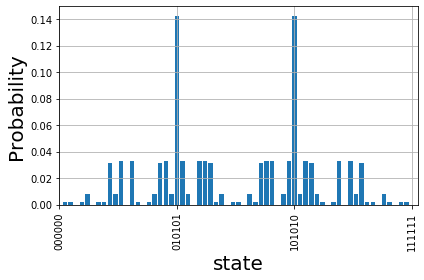

In [15]:
t = np.hstack((betas, gammas))
probs = ring_cut_inst.probabilities(t)
plot(ring_cut_inst, probs)

For larger graphs the probability of sampling the correct string could be significantly smaller, though still peaked around the solution.  Therefore, we would want to increase the probability of sampling the solution relative to any other string.  To do this we simply increase the number of steps $p$ in the algorithm.  We might want to bootstrap the algorithm with angles from lower number of steps.  We can pass inital angles to the solver as optional arguments.

/home/apolloreno/anaconda3/envs/estuary/lib/python3.7/site-packages/pyquil/api/_quantum_computer.py:884: RuntimeWarning: Unable to start qvm server, since the specified port 5000 is in use.
  warnings.warn(RuntimeWarning(warning_msg))
/home/apolloreno/anaconda3/envs/estuary/lib/python3.7/site-packages/pyquil/api/_compiler.py:324: UserWarning: No quilc server running at tcp://127.0.0.1:5555. Compilation using quilc will not be available.
  warnings.warn(f'{e}. Compilation using quilc will not be available.')


                     models will be ineffective
Optimization terminated successfully.
         Current function value: 8.000007
         Iterations: 97
         Function evaluations: 162


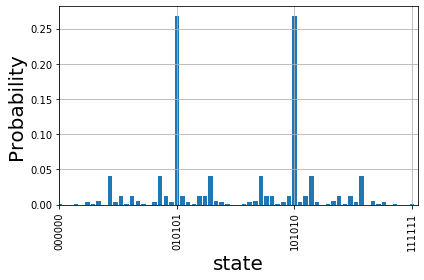

In [16]:
# get the angles from the last run
beta = ring_cut_inst.betas
gamma = ring_cut_inst.gammas
# form new beta/gamma angles from the old angles
betas = np.hstack((beta[0]/3, beta[0]*2/3))
gammas = np.hstack((gamma[0]/3, gamma[0]*2/3))
# set up a new QAOA instance.
with local_forest_runtime():
    qvm = get_qc('6q-qvm')
    ring_cut_inst_2 = QAOA(qvm, range(len(graph.nodes())), steps=2, ref_ham=driver_operators, cost_ham=cost_operators,
                         driver_ref=prog, store_basis=True, init_betas=list(betas), init_gammas=list(gammas))
# run VQE to determine the optimal angles
betas, gammas = ring_cut_inst_2.get_angles()
t = np.hstack((betas, gammas))
probs = ring_cut_inst_2.probabilities(t)
plot(ring_cut_inst_2, probs)

We could also change the optimizer which is passed down to VQE through the QAOA interface.  Let's say I want to use BFGS or another optimizer that can be wrapped in python.  Simply pass it to `QAOA` through the `minimzer`, `minimizer_args`, and `minimizer_kwargs` keywords

/home/apolloreno/anaconda3/envs/estuary/lib/python3.7/site-packages/pyquil/api/_quantum_computer.py:884: RuntimeWarning: Unable to start qvm server, since the specified port 5000 is in use.
  warnings.warn(RuntimeWarning(warning_msg))
/home/apolloreno/anaconda3/envs/estuary/lib/python3.7/site-packages/pyquil/api/_compiler.py:324: UserWarning: No quilc server running at tcp://127.0.0.1:5555. Compilation using quilc will not be available.
  warnings.warn(f'{e}. Compilation using quilc will not be available.')


                     models will be ineffective
Optimization terminated successfully.
         Current function value: 7.500000
         Iterations: 14
         Function evaluations: 176
         Gradient evaluations: 22


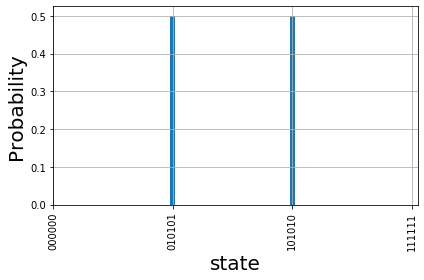

In [17]:
from scipy.optimize import fmin_bfgs

with local_forest_runtime():
    qvm = get_qc('6q-qvm')
    ring_cut_inst_3 = QAOA(qvm, range(len(graph.nodes())), steps=3, ref_ham=driver_operators, cost_ham=cost_operators,
                           driver_ref=prog, store_basis=True, minimizer=fmin_bfgs, minimizer_kwargs={'gtol':1.0e-3},
                           rand_seed=42)
    betas, gammas = ring_cut_inst_3.get_angles()
    t = np.hstack((betas, gammas))
    probs = ring_cut_inst_3.probabilities(t)
    plot(ring_cut_inst_3, probs)

# Let's generate a random (but seeded) k regular graph.

The most popular method to date was first proposed by Bollobás [2], and is called the pairing model (though it is also sometimes referred to as the configuration model). The algorithm itself is simple:

Begin with a set of n vertices.

Create a new set of nk points, distributing them across n buckets, such that each bucket contains k points.

Take each point and pair it randomly with another one, until ½nk pairs are obtained (i.e., a perfect matching).

Collapse the points, so that each bucket (and thus the points it contains) maps onto a single vertex of the original graph. Retain all edges between points as the edges of the corresponding vertices.

Check if the resulting graph is simple. That is to say, make sure that none of the vertices have loops (i.e., self-connections) or multiple edges (i.e., more than one connection to the same vertex). If the graph is not simple, restart.

Algorithm taken from: https://egtheory.wordpress.com/2012/03/29/random-regular-graphs/

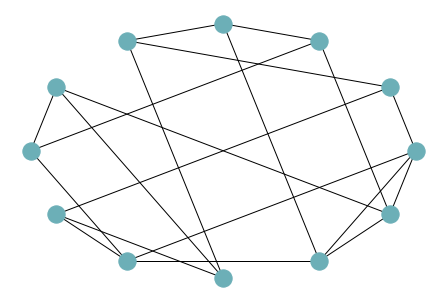

In [15]:
import numpy as np
seed = 137
np.random.seed(seed)
k = 4
num_vertices = 12
n_qubits = num_vertices
def make_graph_instance(num_vertices, k):
    node_edges = [[i,j] for i in range(num_vertices) for j in range(k)]
    pairs = []
    while len(node_edges) > 0:
        el_1 = node_edges.pop(np.random.randint(len(node_edges)))
        el_2 = node_edges.pop(np.random.randint(len(node_edges)))
        pairs.append((el_1, el_2))
    edges = [(pair[0][0], pair[1][0]) for pair in pairs]
    return edges

def make_simple_graph(num_vertices, k):
    simple = True
    edges = make_graph_instance(num_vertices, k)
    for edge in edges:
        if edge[0] == edge[1]:
            simple = False
            break
    if simple:
        return edges
    else:
        return make_simple_graph(num_vertices, k)
        
edges = make_simple_graph(num_vertices, k)
graph = nx.Graph()
for edge in edges:
    graph.add_edge(*edge)
nx.draw_circular(graph, node_color="#6CAFB7")

In [16]:
cost_operators = []
driver_operators = []
for i, j in graph.edges():
    cost_operators.append(PauliTerm("Z", i, 0.5)*PauliTerm("Z", j) + PauliTerm("I", 0, -0.5))
for i in graph.nodes():
    driver_operators.append(PauliSum([PauliTerm("X", i, 1.0)]))

In [17]:
prog = pq.Program()
for i in graph.nodes():
    prog.inst(H(i))

In [18]:
# Be careful, I think there is a reference to an external variable floating around with the ring cut instance.
from pyquil.api import local_forest_runtime
from pyquil import get_qc, Program
def k_regular_maxcut_with_particular_p(p):
    with local_forest_runtime():
        qvm = get_qc(f'{num_vertices}q-qvm')
        cut_inst = QAOA(qvm, range(len(graph.nodes())), steps=p, ref_ham=driver_operators, cost_ham=cost_operators,
                        driver_ref=prog, store_basis=True, rand_seed=42)
    betas, gammas = cut_inst.get_angles()
    from collections import Counter

    # get the parameterized program
    param_prog = cut_inst.get_parameterized_program()
    sampling_prog = param_prog(np.hstack((betas, gammas)))

    # use the run_and_measure QVM API to prepare a circuit and then measure on the qubits
    with local_forest_runtime():
        qvm = get_qc(f'{num_vertices}q-qvm')
        bitstring_samples = qvm.run_and_measure(sampling_prog, 1000)
        shots = np.array([bitstring_samples[qubit] for qubit in sorted(bitstring_samples)]).T
        bitstring_tuples = map(tuple, shots)

    # aggregate the statistics
    freq = Counter(bitstring_tuples)
    most_frequent_bit_string = max(freq, key=lambda x: freq[x])
    print("The most frequently sampled string is ", most_frequent_bit_string)
    n_qubits = graph.number_of_nodes()
    t = np.hstack((betas, gammas))
    probs = cut_inst.probabilities(t)
    plot(cut_inst, probs)
    return most_frequent_bit_string

/home/apolloreno/anaconda3/envs/estuary/lib/python3.7/site-packages/pyquil/api/_quantum_computer.py:884: RuntimeWarning: Unable to start qvm server, since the specified port 5000 is in use.
  warnings.warn(RuntimeWarning(warning_msg))


                     models will be ineffective
Optimization terminated successfully.
         Current function value: 98.315049
         Iterations: 15
         Function evaluations: 29


/home/apolloreno/anaconda3/envs/estuary/lib/python3.7/site-packages/pyquil/api/_quantum_computer.py:884: RuntimeWarning: Unable to start qvm server, since the specified port 5000 is in use.
  warnings.warn(RuntimeWarning(warning_msg))


The most frequently sampled string is  (1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0)


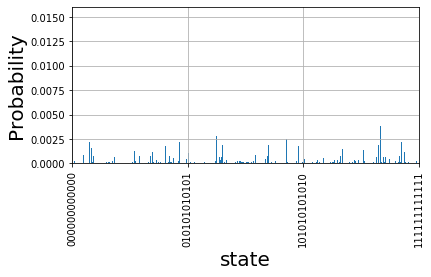

In [19]:
cut = k_regular_maxcut_with_particular_p(1)

In [20]:
from networkx.algorithms.cuts import cut_size
def cut_to_cut_set(cut):
    cut_set = []
    for i, node in enumerate(cut):
        if node == 1:
            cut_set.append(i)
    cut_size(graph, cut_set)
    return cut_set
cut_size(graph, cut_to_cut_set(cut))

18

In [24]:
max_cut = 0
for cut_string in range(2**graph.number_of_nodes()):
    cut_string = list([int(s) for s in bin(cut_string)[2:]])
    prepend = [0 for _ in range(graph.number_of_nodes() - len(cut_string))]
    cut_string = prepend + cut_string
    max_cut = max(max_cut, cut_size(graph, cut_to_cut_set(cut_string)))